In [20]:
import copy,re,sys
from pdastro import pdastroclass,pdastrostatsclass,unique
import pandas as pd
from astropy.io import fits
import numpy as np

imnames=['nrc30/v1/jw01070001001_02101_00001_nrcalong_tweakregstep.fits',
        'nrc30/v1/jw01070001001_06101_00001_nrcalong_tweakregstep.fits',
        'nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.fits'
        ]

imnames=['nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.fits',
         'nrc30/v1/jw01070001001_04101_00004_nrcalong_tweakregstep.fits']


photname=list(np.empty(len(imnames)))
phots = list(np.empty(len(imnames)))
copy_suffix = list(np.empty(len(imnames)))
for i in range(len(imnames)): 
    photname[i] = re.sub('\.fits$','.good.phot.txt',imnames[i])
    if photname[i] == imnames[i]: 
        raise RuntimeError(f'BUG!!! {photname[i]}')
    im = fits.open(imnames[i])
    aperture = im['PRIMARY'].header['APERNAME']
    pupil = re.sub('MASK','',im['PRIMARY'].header['PUPIL'])
    obsnum = im['PRIMARY'].header['OBSERVTN']
    phots[i]= pdastrostatsclass()
    phots[i].load(photname[i])
    if 'gaia_source_id' in phots[i].t.columns:
        phots[i].t['gaia_source_id']=phots[i].t['gaia_source_id'].astype(pd.Int64Dtype())
    copy_suffix[i] = f'{obsnum}_{pupil}'
    print(f'{photname[i]}: {aperture} {pupil} {obsnum} ({len(phots[i].t)} rows): {copy_suffix[i]}')
    

nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 001 (174 rows): 001_RND
nrc30/v1/jw01070001001_04101_00004_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 001 (175 rows): 001_RND


In [21]:
phots[1].write()
# add all coordinate columns to each phot file: x/y_idl, v2/v3

 aper_sum_3.5px  annulus_median_3.5px  aper_bkg_3.5px  aper_sum_bkgsub_3.5px  flux_err_3.5px       mag     dmag           x           y  sharpness  roundness1  roundness2        ra        dec      x_idl      y_idl   gaia_ra   gaia_dec  gaia_ID      gaia_source_id  gaia_ra_error  gaia_dec_error    gaia_g  gaia_g_err   gaia_rp  gaia_rp_err  gaia_g_rp  gaia_g_rp_err   __weights  d_rot_tmp  __tmp_residuals  delta_mag      gaia_x      gaia_y        dx        dy
     585.278964              1.099920       42.815017             542.463947        9.094164 -6.835927 0.018206  143.051301    9.322211   0.708425    0.411459    0.340841 80.461174 -69.505271 -55.517681 -63.275960 80.461172 -69.505271   2142.0 4657987797455493120       0.047465        0.046670 16.570309    0.001030 15.548953     0.005188   1.021356       5.727582  542.463947   0.227788         0.063131 -23.406236  143.021271    9.323766 -0.030030  0.001556
      37.522441              0.136952        5.330923              32.191518  

0

In [25]:
def find_matches(phot0, phot1, suffix4copycol, ixs_phot0=None, ixs_phot1=None, refcat_prefix='gaia',
                cols2copy=['ra','dec','x_idl','y_idl']):
    Ndouble = 0
    idcol = f'{refcat_prefix}_source_id'
    ixs_phot0 = phot0.getindices(ixs_phot0)
    ixs_phot1 = phot1.getindices(ixs_phot1)
    ix0_singlematch=[]
    ix1_singlematch=[]
    for ix0 in ixs_phot0:
        ID = phot0.t.loc[ix0,idcol]
        ix1_match = phot1.ix_equal(idcol,ID,indices=ixs_phot1)
        #print(f'{ID}: {len(ixs_match)}')
        if len(ix1_match)==1:
            ix0_singlematch.append(ix0)
            ix1_singlematch.append(ix1_match[0])
    print(f'matches: {len(ix0_singlematch)}')
    for sourcecol in ['x','y','x_idl','y_idl','ra','dec']:
        destcol = f'{sourcecol}_{suffix4copycol}'
        phot0.t.loc[ix0_singlematch,destcol]=list(phot1.t.loc[ix1_singlematch,sourcecol])
    return(ix0_singlematch)

diff_mean = pdastrostatsclass()
diff_mean.t['diffname']=None
diff_mean.param2columnmapping = diff_mean.intializecols4statparams()

outcols= ['mag','dmag','x','y','ra','dec','x_idl','y_idl','gaia_ra','gaia_dec','gaia_source_id']
ixs0_keep = []
for i in range(1,len(imnames)):
    ixs0_match = find_matches(phots[0],phots[i],copy_suffix[i])
    for col0 in ['x','y','x_idl','y_idl']:
        # get column names
        coli = f'{col0}_{copy_suffix[i]}'
        dcol = f'diff_{col0}_{copy_suffix[i]}'
        #print(col0,coli,dcol)
        
        # calculate difference
        phots[0].t.loc[ixs0_match,dcol] =  phots[0].t.loc[ixs0_match,coli] - phots[0].t.loc[ixs0_match,col0] 
        
        # keep the columns for the output
        outcols.extend([coli,dcol])
        
        # do statistics!
        phots[0].calcaverage_sigmacutloop(dcol,verbose=3,indices=ixs0_match,percentile_cut_firstiteration=80)
        print(phots[0].statstring())

        ix_result = diff_mean.newrow({'diffname':dcol})
        diff_mean.statresults2table(phots[0].statparams,
                                    diff_mean.param2columnmapping,
                                    destindex=ix_result)
    ixs0_keep.extend(ixs0_match)
ixs0_keep = unique(ixs0_keep)
#sys.exit(0)
#ix0_match = find_matches(phots[0],phots[1],copy_suffix='001')
print(phots[0].t.columns)
#phots[0].write(columns=outcols,indices=ixs0_keep)
outfilename = re.sub('\.txt$','.matches.txt',photname[0])
if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
print(f'Saving matches to {outfilename}')
phots[0].write(outfilename,columns=outcols,indices=ixs0_keep)

diff_mean.write(outfilename)
outfilename = re.sub('\.txt$','.mean.txt',photname[0])
if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
print(f'Saving mean value stats to {outfilename}')
diff_mean.write(outfilename)
#phots[0].write(columns=['x','y','ra','dec','x_idl','y_idl','x_idl001_BAR','d_x_idl_x_idl001_BAR'])
#phots[0].write()
#print(phots[0].t['x_idl001'])

matches: 14
Keeping 14 out of 14, skippin 0 because of null values in columns diff_x_001_RND
median: 3.536082
80.000000 percentile cut: max residual for cut: 0.124437
median: 3.532099
i:00 mean:3.532099(0.019347) stdev:0.061181(0.013044) X2norm:0.95 Nchanged:0 Ngood:11 Nclip:3

mean: 3.547951
i:01 mean:3.547951(0.023766) stdev:0.082328(0.016146) X2norm:1.00 Nchanged:2 Ngood:13 Nclip:1

mean: 3.561865
i:02 mean:3.561865(0.026264) stdev:0.094695(0.017896) X2norm:1.00 Nchanged:1 Ngood:14 Nclip:0

mean: 3.561865
i:03 mean:3.561865(0.026264) stdev:0.094695(0.017896) X2norm:1.00 Nchanged:0 Ngood:14 Nclip:0
i:03 mean:3.561865(0.026264) stdev:0.094695(0.017896) X2norm:1.00 Nchanged:0 Ngood:14 Nclip:0
Keeping 14 out of 14, skippin 0 because of null values in columns diff_y_001_RND
median: 0.728591
80.000000 percentile cut: max residual for cut: 0.053897
median: 0.726165
i:00 mean:0.726165(0.009346) stdev:0.029556(0.006301) X2norm:0.95 Nchanged:0 Ngood:11 Nclip:3

mean: 0.718785
i:01 mean:0.7187

0

<AxesSubplot:xlabel='y', ylabel='diff_y_idl_001_RND'>

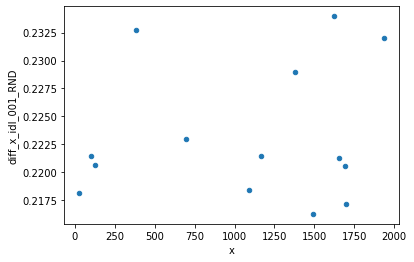

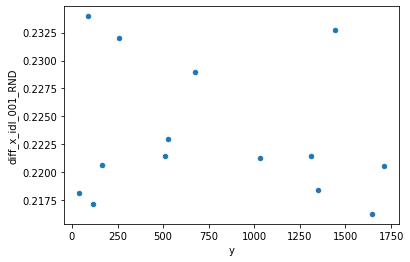

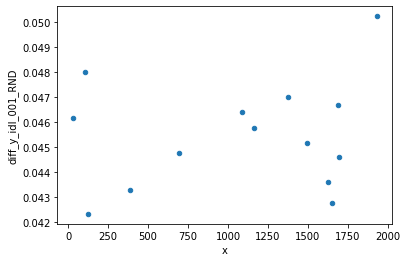

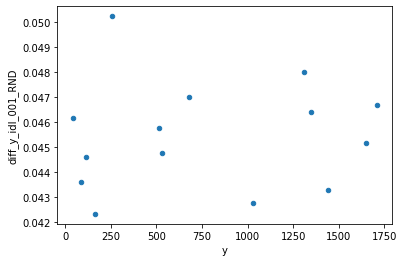

In [26]:
phots[0].t.plot.scatter('x','diff_x_idl_001_RND')
phots[0].t.plot.scatter('y','diff_x_idl_001_RND')
phots[0].t.plot.scatter('x','diff_y_idl_001_RND')
phots[0].t.plot.scatter('y','diff_y_idl_001_RND')